# Newsvendor Intro Example

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters, plot_contours, plot_contours_line
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":24,
    "font.family": "serif"
})

### Example 1: Intro example, max of affine uncertainty
We consider a problem with max of affine uncertainty, 

$$g(u,x) = \max_{l=1,\dots,L} (P_lu + a_l)^Tx,$$
where $P_l$ and $a_l$ are constants for all $l = 1, \dots, L$. The robust formulation is 
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & \max_{l=1,\dots,L} (P_lu + a_l)^Tx  \leq  \tau \quad \forall u \in \mathcal{U}(\theta)\\
& x \geq 0,
\end{array}
$$


where $\theta$ encodes the training parameters $(A,b)$.

We formulate the Newsvendor problem with this framework, where we solve
\begin{equation}
	\begin{array}{ll}
		\text{minimize} & \tau\\
		\text{subject to} & k^Tx  + \max\{-p^Tx,- p^Tu\} \le \tau \quad \forall u \in \mathcal{U}(\theta) \\
		& x \geq 0.
	\end{array}
\end{equation}

In [2]:
# Formulate constants
n = 2
N = 1000
test_perc = 0.9
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k = np.array([4.,5.])
p = np.array([5,6.5])

def loss(t,x,k_tch, p_tch, alpha,data, l = 5, quantile = 0.95,target = 1.): 
    sums = torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@(p_tch), k_tch@x - x@(p_tch)) - t - alpha, 
        torch.tensor(0.,requires_grad = True)))
    sums = sums/(1-quantile) + alpha
    eval_obj = torch.mean(torch.maximum(k_tch@x -data@(p_tch), k_tch@x - x@(p_tch)))
    prob_violations = torch.mean((torch.maximum(
        torch.maximum(k_tch@x -data@(p_tch), k_tch@x - x@(p_tch)) - t, 
        torch.tensor(0.,requires_grad = True))>=0.001).float())
    return t + l*(sums - target), eval_obj, prob_violations, sums.detach().numpy()


def gen_demand_intro(N, seed):
    np.random.seed(seed)
    sig = np.array([[0.6,-0.4],[-0.3,0.1]])
    mu = np.array((0.9,0.7))
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

# Generate data
data = gen_demand_intro(N, seed=5)

#Generate instances of y
instances = {}
num_instances = 8
for instance in range(num_instances):
  np.random.seed(instance+1)
  instances[instance]={}
  instances[instance][0] = np.random.uniform(2,6,n)
  instances[instance][1] =  instances[instance][0] + np.random.uniform(2,4,n)

### Repeat training for many runs

In [3]:
num_experiments = 3
for experiment in range(num_experiments):
  data = gen_demand_intro(N, seed= 15+experiment)
  # Formulate uncertainty set
  u = lropt.UncertainParameter(n,
                          uncertainty_set=lropt.Ellipsoidal(p=2,
                                                      data=data, loss = loss))
  # Formulate the Robust Problem
  x_r = cp.Variable(n)
  t = cp.Variable()
  k = cp.Parameter(2)
  p = cp.Parameter(2)
  k.value = instances[0][0]
  p.value = instances[0][1]
  # y = cp.Variable()

  objective = cp.Minimize(t)

  constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
  constraints += [x_r >= 0]

  prob = lropt.RobustProblem(objective, constraints)
  target = -0.05
  s = 13

  # setup intial A, b
  train, test = train_test_split(data, test_size=int(data.shape[0]*test_perc), random_state=s)
  init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
  init_bval = -init@np.mean(train, axis=0)

  # Train A and b
  result1 = prob.train(lr = 0.0007,step_y = 0.01,step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_lam = 0.05, target_cvar = target, init_alpha = -0.1, test_percentage = test_perc, scenarios = instances, num_scenarios = num_instances, batch_percentage = 1.0)
  df1 = result1.df
  A_fin = result1.A
  b_fin = result1.b

  # Grid search standard
  result4 = prob.grid(epslst = np.logspace(-3, 2, 100), init_A = init, init_b = init_bval, seed = s, init_alpha = -0., test_percentage = test_perc,scenarios = instances, num_scenarios = num_instances)
  dfgrid = result4.df

  # Grid search reshaped
  result5 = prob.grid(epslst = np.logspace(-3, 2, 100), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = -0., test_percentage = test_perc,scenarios = instances, num_scenarios = num_instances)
  dfgrid2 = result5.df

  if experiment == 0:
    cur_df1 = dfgrid.copy()
    cur_df2 = dfgrid2.copy()
  else:
    cur_df1 = cur_df1 + dfgrid.copy()
    cur_df2 = cur_df2 + dfgrid2.copy()

cur_df1["Eps"] = cur_df1["Eps"]/num_experiments
cur_df1["coverage_train"] = cur_df1["coverage_train"]/num_experiments
cur_df1["coverage_test"] = cur_df1["coverage_test"]/num_experiments
cur_df2["Eps"] = cur_df2["Eps"]/num_experiments
cur_df2["coverage_train"] = cur_df2["coverage_train"]/num_experiments
cur_df2["coverage_test"] = cur_df2["coverage_test"]/num_experiments

### Plot objective and violations (for many runs)

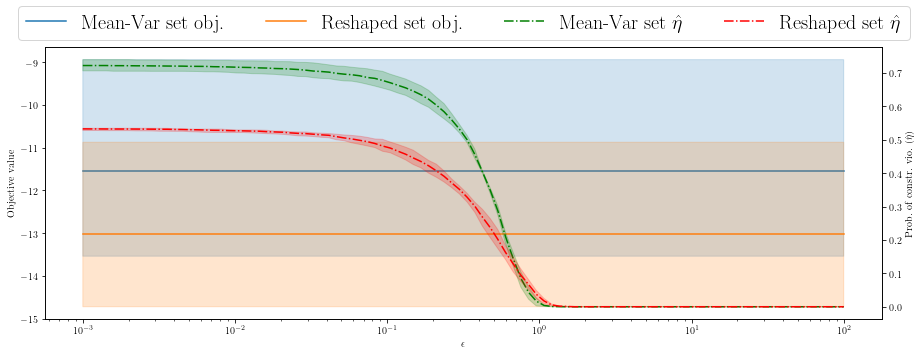

In [ ]:
#plot for many runs
df_st, df_re = cur_df1, cur_df2

#plot for one run (last run in loop)
# df_st, df_re = dfgrid, dfgrid2

fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()
ax1.plot(np.mean(np.vstack(df_st['Eps']),axis = 1)[:], np.mean(np.vstack(df_st['Test_val']),axis = 1)[:], color="tab:blue",label=r"Mean-Var set obj.",zorder=0)
ax1.fill(np.append(np.quantile(np.vstack(df_st['Eps']),0.25,axis = 1),np.quantile(np.vstack(df_st['Eps']),0.75,axis = 1)[::-1]), np.append(np.quantile(np.vstack(df_st['Test_val']),0.25,axis = 1),np.quantile(np.vstack(df_st['Test_val']),0.75,axis = 1)[::-1]), color="tab:blue", alpha=0.2)

ax1.plot(np.mean(np.vstack(df_re['Eps']),axis = 1),np.mean(np.vstack(df_re['Test_val']),axis = 1), color="tab:orange", label="Reshaped set obj.",zorder=1)
ax1.fill(np.append(np.quantile(np.vstack(df_re['Eps']),0.25,axis = 1),np.quantile(np.vstack(df_re['Eps']),0.75,axis = 1)[::-1]), np.append(np.quantile(np.vstack(df_re['Test_val']),0.25,axis = 1),np.quantile(np.vstack(df_re['Test_val']),0.75,axis = 1)[::-1]), color="tab:orange", alpha=0.2)
ax1.set_ylabel("Objective value")
# ax2.set_xlim([-1,20])
ax1.set_xlabel(r"$\epsilon$")
# ax1.set_ylim([-20,1])
ax1.set_xscale("log")


ax2.plot(np.mean(np.vstack(df_st['Eps']),axis = 1)[:], np.mean(np.vstack(df_st['Violations']),axis = 1)[:], color="green", label=r"Mean-Var set $\hat{\eta}$", linestyle="-.", zorder=0)
ax2.fill(np.append(np.quantile(np.vstack(df_st['Eps']),0.25,axis = 1),np.quantile(np.vstack(df_st['Eps']),0.75,axis = 1)[::-1]), np.append(np.quantile(np.vstack(df_st['Violations']),0.25,axis = 1),np.quantile(np.vstack(df_st['Violations']),0.75,axis = 1)[::-1]), color="green", alpha=0.2)
    

ax2.plot(np.mean(np.vstack(df_re['Eps']),axis = 1),np.mean(np.vstack(df_re['Violations']),axis = 1), color="red", label=r"Reshaped set $\hat{\eta}$", linestyle="-.", zorder=1)
ax2.fill(np.append(np.quantile(np.vstack(df_re['Eps']),0.25,axis = 1),np.quantile(np.vstack(df_re['Eps']),0.75,axis = 1)[::-1]), np.append(np.quantile(np.vstack(df_re['Violations']),0.25,axis = 1),np.quantile(np.vstack(df_re['Violations']),0.75,axis = 1)[::-1]), color="red", alpha=0.2)
ax2.set_ylabel("Prob. of constr. vio. $(\hat{\eta})$")

fig.legend(bbox_to_anchor=(0.1, 0.9, 0, 0), loc="lower left",
                 borderaxespad=0, ncol=4, fontsize = 20)
plt.savefig("obj_violations.pdf", bbox_inches='tight')


### Plot objective vs violations (for many runs)

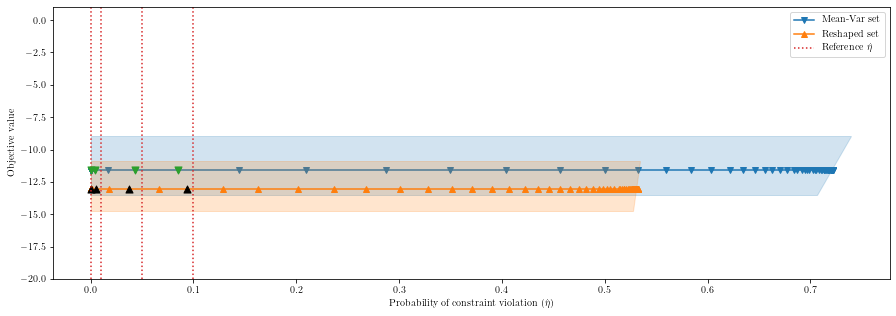

In [ ]:
#plot for many runs
df_st, df_re = cur_df1, cur_df2

#plot for one run (last run in loop)
# df_st, df_re = dfgrid, dfgrid2

eps_list = np.logspace(-3, 2, 100)
prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(df_st['Violations']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(df_re['Violations']),axis = 1)-i).argmin())
st_eps = eps_list [inds_standard[0]]
re_eps = eps_list [inds_reshaped[0]]

plt.figure(figsize=(15, 5))
plt.plot(np.mean(np.vstack(df_st['Violations']),axis = 1)[:], np.mean(np.vstack(df_st['Test_val']),axis = 1)[:], color="tab:blue", label=r"Mean-Var set", marker = "v",zorder=0)
plt.fill(np.append(np.quantile(np.vstack(df_st['Violations']),0.25,axis = 1),np.quantile(np.vstack(df_st['Violations']),0.75,axis = 1)[::-1]), np.append(np.quantile(np.vstack(df_st['Test_val']),0.25,axis = 1),np.quantile(np.vstack(df_st['Test_val']),0.75,axis = 1)[::-1]), color="tab:blue", alpha=0.2)
for ind in range(4):
    plt.scatter(np.mean(np.vstack(df_st['Violations']),axis = 1)[inds_standard[ind]],np.mean(np.vstack(df_st['Test_val']),axis = 1)[inds_standard[ind]], color="tab:green", s = 50, marker = "v",zorder= 10)


plt.plot(np.mean(np.vstack(df_re['Violations']),axis = 1),np.mean(np.vstack(df_re['Test_val']),axis = 1), color="tab:orange", label="Reshaped set", marker = "^",zorder=1)
plt.fill(np.append(np.quantile(np.vstack(df_re['Violations']),0.25,axis = 1),np.quantile(np.vstack(df_re['Violations']),0.75,axis = 1)[::-1]), np.append(np.quantile(np.vstack(df_re['Test_val']),0.25,axis = 1),np.quantile(np.vstack(df_re['Test_val']),0.75,axis = 1)[::-1]), color="tab:orange", alpha=0.2)
for ind in [0,2,1,3]:
    plt.scatter(np.mean(np.vstack(df_re['Violations']),axis = 1)[inds_reshaped[ind]],np.mean(np.vstack(df_re['Test_val']),axis = 1)[inds_reshaped[ind]], color="black", s = 50, marker = "^")

plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
#plt.xscale("log")
plt.ylim([-20,1])
plt.vlines(ymin = -20, ymax= 1, x = prob_list[0], linestyles=":", color = "tab:red", label = "Reference $\hat{\eta}$")
for i in prob_list[1:]:
    plt.vlines(ymin = -20, ymax= 1, x = i, linestyles=":", color = "tab:red")

plt.legend()
plt.savefig("ex1_curves_orig.pdf", bbox_inches='tight')


### Plot sets (for one run)

In [ ]:
eps_list = np.logspace(-3, 2, 100)
prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Violations']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Violations']),axis = 1)-i).argmin())

x_opt_base = {}
x_opt_learned = {}
t_learned = {}
t_base = {}
for ind in range(4):
    x_opt_base[ind] = {}
    x_opt_learned[ind] = {}
    t_learned[ind] = {}
    t_base[ind] = {}
    for instance in range(num_instances):
        n = 2
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,
                                                            A = (1/eps_list[inds_standard[ind]])*init, b = (1/eps_list[inds_standard[ind]])*init_bval))
        # Formulate the Robust Problem
        x_r = cp.Variable(n)
        t = cp.Variable()
        k = instances[instance][0]
        p = instances[instance][1]
        # y = cp.Variable()

        objective = cp.Minimize(t)

        constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
        # constraints += [cp.maximum(k1@(x_r-u),0) <= y]
        # constraints = [cp.maximum(u@k + k1@x_r -u@(k + k1), u@k + k1@x_r - x_r@(k + k1))<=t]

        constraints += [x_r >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        # result3.reform_problem.solve()
        x_opt_base[ind][instance] = x_r.value

        t_base[ind][instance] = t.value

        n = 2
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,
                                                            A = (1/eps_list[inds_reshaped[ind]])*A_fin, b = (1/eps_list[inds_reshaped[ind]])*b_fin))
        # Formulate the Robust Problem
        x_r = cp.Variable(n)
        t = cp.Variable()
        k = instances[instance][0]
        p = instances[instance][1]
        # y = cp.Variable()

        objective = cp.Minimize(t)

        constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
        # constraints += [cp.maximum(k1@(x_r-u),0) <= y]
        # constraints = [cp.maximum(u@k + k1@x_r -u@(k + k1), u@k + k1@x_r - x_r@(k + k1))<=t]

        constraints += [x_r >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        # result3.reform_problem.solve()
        x_opt_learned[ind][instance] = x_r.value

        t_learned[ind][instance] = t.value
        x_opt_learned,x_opt_base,t_learned, t_base
    # A_fin, init, b_fin, init_bval
# x_opt_learned,x_opt_base,t_learned, t_base
A_fin, b_fin, init, init_bval

(array([[ 0.6978916 , -0.230466  ],
        [ 0.23308593,  0.7194691 ]]),
 array([-1.33617935, -2.32974814]),
 array([[0.27994147, 0.11590149],
        [0.11590149, 0.84733389]]),
 array([-1.33617935, -2.32974814]))

In [ ]:
K =1
num_p = 50
offset = 2
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(4):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
g_level_learned = {}
g_level_base = {}
for ind in range(4):
    g_level_learned[ind] = {}
    g_level_base[ind] = {}
    for instance in range(num_instances):
        g_level_learned[ind][instance] = np.zeros((num_p,num_p))
        g_level_base[ind][instance] = np.zeros((num_p,num_p))
# init_set = np.zeros((num_p,num_p))
    # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_reshaped[ind]])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/eps_list[inds_reshaped[ind]])*b_fin)

            for k_ind in range(K):
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_standard[ind]])*init[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  + (1/eps_list[inds_standard[ind]])*init_bval)
            
            for instance in range(num_instances):
                g_level_learned[ind][instance][i,j] = np.maximum(instances[instance][0] @ x_opt_learned[ind][instance] - instances[instance][1] @ x_opt_learned[ind][instance], instances[instance][0] @ x_opt_learned[ind][instance] - instances[instance][1] @ u_vec) - t_learned[ind][instance]
                g_level_base[ind][instance][i,j] = np.maximum(instances[instance][0] @ x_opt_base[ind][instance] - instances[instance][1] @ x_opt_base[ind][instance], instances[instance][0] @ x_opt_base[ind][instance] - instances[instance][1] @ u_vec) - t_base[ind][instance]

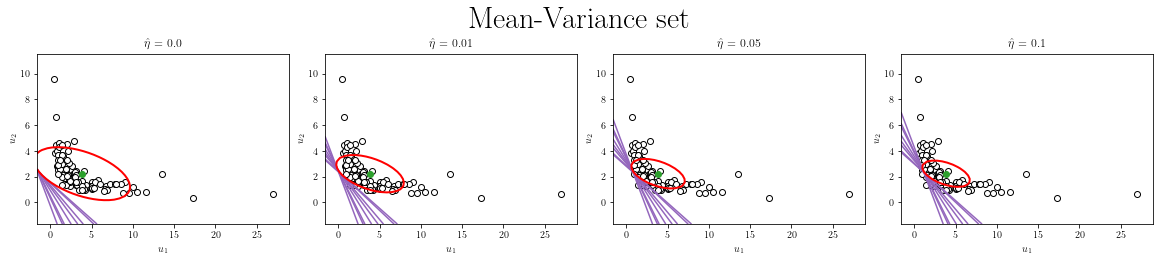

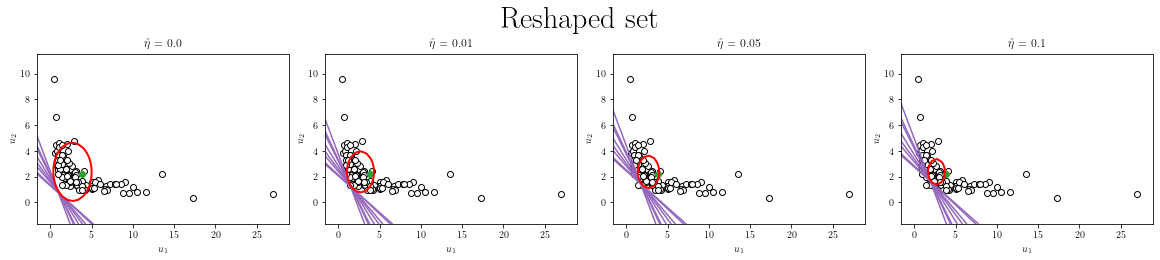

In [ ]:
plot_contours_line(x,y,init_set, g_level_base,prob_list,num_instances,train, "news_intro",standard = True) 
plot_contours_line(x,y,fin_set, g_level_learned,prob_list,num_instances,train, "news_intro",standard = False)

### Verify dualization with cvxpy

In [105]:
h = np.array([2,2.3])
h_tch = torch.tensor(h)
rho = 1
Amat= (1/rho)*A_fin
bvec = (1/rho)* b_fin
u = lropt.UncertainParameter(n,
                             uncertainty_set=lropt.Ellipsoidal(p=2, rho=1,A = Amat, b = bvec))
# formulate cvxpy variables
x_r = cp.Variable(n)
t1 = cp.Variable()
t2 = cp.Variable()

# formulate constants

# formulate objective
objective = cp.Minimize(t1 + t2)

# formulate constraints 
constraints = [cp.maximum(k@x_r - p@x_r - t1, k@x_r - p@u-t1,h@u - h@x_r - t2, -t2 ) <= 0]
constraints += [x_r >= 0]

# formulate Robust Problem
prob_robust = lropt.RobustProblem(objective, constraints)

# solve
prob_robust.solve()
print("LRO objective value: ", prob_robust.objective.value, "\nLRO x: ", x_r.value)
print("LRO t value: ", t1.value, t2.value)

LRO objective value:  15.554291327455623 
LRO x:  [2.69555073 2.36487321]
LRO t value:  4.655715393117413 10.89857593433821


In [106]:
# formulate using cvxpy
x_cvxpy = cp.Variable(n)
t1 = cp.Variable()
t2 = cp.Variable()
lam = cp.Variable()

# formulate objective
objective = cp.Minimize(t1 + t2)

# formulate constraints
constraints = [(k-p)@x_cvxpy+ lam <= t1]
constraints += [k@x_cvxpy -bvec@np.linalg.inv(Amat.T)@(-p) + lam <= t1]
constraints += [-h@x_cvxpy -bvec@np.linalg.inv(Amat.T)@(h) + lam <= t2]
constraints += [lam <= t2]
constraints += [lam >= cp.norm(np.linalg.inv(Amat.T)@-p,2)]
constraints += [lam >= cp.norm(np.linalg.inv(Amat.T)@h,2)]
constraints += [x_cvxpy >= 0]

# formulate problem 
prob_cvxpy = cp.Problem(objective, constraints)
prob_cvxpy.solve()
print("Cvxpy objective value: ", prob_cvxpy.objective.value, "\nCvxpy x: ", x_cvxpy.value)
print("Cvxpy t value: ", t1.value, t2.value)

Cvxpy objective value:  15.554291328098326 
Cvxpy x:  [2.69555073 2.36487321]
Cvxpy t value:  4.6557153937497535 10.898575934348573


In [98]:
lam1 = constraints[0].dual_value
lam2 = constraints[1].dual_value
lam3 = constraints[2].dual_value
lam1, lam2, lam3, -lam1*p + k - lam3

(0.5333333333474415,
 0.4666666666865766,
 0.6666666667115495,
 array([0.66666667, 0.86666667]))

In [31]:
lam1 = constraints[0].dual_value
lam2 = constraints[1].dual_value
lam3 = constraints[2].dual_value
lam1, lam2, lam3, -lam1*p + k - lam3

(0.5950665211449148,
 0.4049334789555226,
 array([9.54556191e-11, 5.56723177e-01]),
 array([-7.34378312e-10, -7.23159310e-10]))

In [46]:
(k-p)@x_cvxpy.value+ np.linalg.norm(np.linalg.inv(Amat.T)@p,2),k@x_cvxpy.value -bvec@np.linalg.inv(Amat.T)@(-p) + np.linalg.norm(np.linalg.inv(Amat.T)@p,2), t.value

(-1.4958977461972154, -1.4958977463751317, array(-1.49589775))

In [48]:
-x_cvxpy.value@p, bvec@np.linalg.inv(Amat.T)@p

(-46.01782102778157, -46.017821027959485)